<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:08:36] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


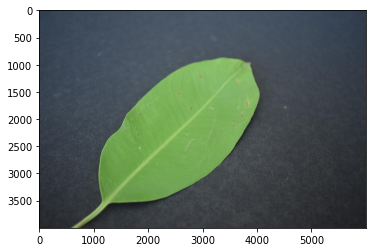

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

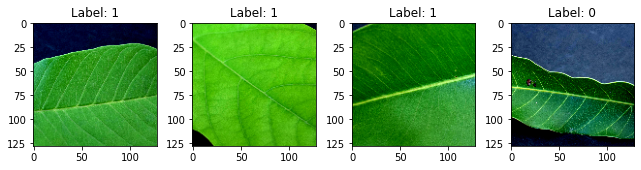

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:08:41] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:08:43] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2559840201541779 samples/sec                   batch loss = 1.401226282119751 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2673970038839548 samples/sec                   batch loss = 0.33464181423187256 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2646986057814007 samples/sec                   batch loss = 0.6585384607315063 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2776140261739588 samples/sec                   batch loss = 0.383876770734787 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.2755381660936562 samples/sec                   batch loss = 0.9240171909332275 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.2591618474594257 samples/sec                   batch loss = 0.8407917022705078 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2643455820368625 samples/sec                   batch loss = 0.42165470123291016 | accuracy = 0.6214285714285714


Epoch[1] Batch[40] Speed: 1.2555913959905562 samples/sec                   batch loss = 0.5446034073829651 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2733001942067066 samples/sec                   batch loss = 1.8332940340042114 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.272222449292044 samples/sec                   batch loss = 0.3564871847629547 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2674842314435544 samples/sec                   batch loss = 0.5251356363296509 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2726334609465018 samples/sec                   batch loss = 0.6045680642127991 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2668807783653953 samples/sec                   batch loss = 1.0900814533233643 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.2721279126838778 samples/sec                   batch loss = 0.40132901072502136 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.2757016896271511 samples/sec                   batch loss = 0.5575053095817566 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2723865711970639 samples/sec                   batch loss = 0.3933764696121216 | accuracy = 0.621875


Epoch[1] Batch[85] Speed: 1.241685579980411 samples/sec                   batch loss = 0.5205816030502319 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.2693208044653006 samples/sec                   batch loss = 1.0664674043655396 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.2697411863787595 samples/sec                   batch loss = 1.003122329711914 | accuracy = 0.6342105263157894


Epoch[1] Batch[100] Speed: 1.2647795507146549 samples/sec                   batch loss = 0.6267669200897217 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.270320051111987 samples/sec                   batch loss = 0.3842223882675171 | accuracy = 0.6428571428571429


Epoch[1] Batch[110] Speed: 1.2736651986719798 samples/sec                   batch loss = 0.6079196929931641 | accuracy = 0.6477272727272727


Epoch[1] Batch[115] Speed: 1.2690098280622362 samples/sec                   batch loss = 0.7405063509941101 | accuracy = 0.65


Epoch[1] Batch[120] Speed: 1.2679536087768437 samples/sec                   batch loss = 0.5102455019950867 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.2597808593716855 samples/sec                   batch loss = 0.6433839797973633 | accuracy = 0.656


Epoch[1] Batch[130] Speed: 1.268158998801474 samples/sec                   batch loss = 0.4714480936527252 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2717843229528 samples/sec                   batch loss = 0.5309703946113586 | accuracy = 0.662962962962963


Epoch[1] Batch[140] Speed: 1.2685812012705158 samples/sec                   batch loss = 0.6911033391952515 | accuracy = 0.6607142857142857


Epoch[1] Batch[145] Speed: 1.2651902508078992 samples/sec                   batch loss = 0.5787351727485657 | accuracy = 0.6620689655172414


Epoch[1] Batch[150] Speed: 1.2652382436242677 samples/sec                   batch loss = 0.9344308376312256 | accuracy = 0.6583333333333333


Epoch[1] Batch[155] Speed: 1.2682072171150816 samples/sec                   batch loss = 0.8417291641235352 | accuracy = 0.6548387096774193


Epoch[1] Batch[160] Speed: 1.2637210301502466 samples/sec                   batch loss = 1.0694854259490967 | accuracy = 0.6578125


Epoch[1] Batch[165] Speed: 1.2659451996228095 samples/sec                   batch loss = 0.5418094992637634 | accuracy = 0.6590909090909091


Epoch[1] Batch[170] Speed: 1.267426301812947 samples/sec                   batch loss = 0.6393812894821167 | accuracy = 0.6588235294117647


Epoch[1] Batch[175] Speed: 1.266921341486069 samples/sec                   batch loss = 0.5174064636230469 | accuracy = 0.6585714285714286


Epoch[1] Batch[180] Speed: 1.263272377730821 samples/sec                   batch loss = 0.6324989199638367 | accuracy = 0.6597222222222222


Epoch[1] Batch[185] Speed: 1.2676509642772895 samples/sec                   batch loss = 0.5014129281044006 | accuracy = 0.6621621621621622


Epoch[1] Batch[190] Speed: 1.2662486547649228 samples/sec                   batch loss = 0.5636466145515442 | accuracy = 0.6618421052631579


Epoch[1] Batch[195] Speed: 1.2591213071998042 samples/sec                   batch loss = 0.48134633898735046 | accuracy = 0.6653846153846154


Epoch[1] Batch[200] Speed: 1.2652829002502026 samples/sec                   batch loss = 0.6657720804214478 | accuracy = 0.6675


Epoch[1] Batch[205] Speed: 1.2739344461835498 samples/sec                   batch loss = 0.5968524813652039 | accuracy = 0.6670731707317074


Epoch[1] Batch[210] Speed: 1.276948697417974 samples/sec                   batch loss = 0.4268764555454254 | accuracy = 0.6666666666666666


Epoch[1] Batch[215] Speed: 1.2674573246259624 samples/sec                   batch loss = 0.36872974038124084 | accuracy = 0.663953488372093


Epoch[1] Batch[220] Speed: 1.259326397782137 samples/sec                   batch loss = 0.5108928680419922 | accuracy = 0.6625


Epoch[1] Batch[225] Speed: 1.26080635106959 samples/sec                   batch loss = 0.7612560391426086 | accuracy = 0.6611111111111111


Epoch[1] Batch[230] Speed: 1.2666302821226538 samples/sec                   batch loss = 0.5273743867874146 | accuracy = 0.6630434782608695


Epoch[1] Batch[235] Speed: 1.2599630765052918 samples/sec                   batch loss = 0.3789757788181305 | accuracy = 0.6659574468085107


Epoch[1] Batch[240] Speed: 1.2648930245406595 samples/sec                   batch loss = 1.0942071676254272 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.2685669091054816 samples/sec                   batch loss = 0.47698327898979187 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2688911038923076 samples/sec                   batch loss = 0.5587409138679504 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2651748900593238 samples/sec                   batch loss = 0.35760071873664856 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.26057662542189 samples/sec                   batch loss = 0.6313158273696899 | accuracy = 0.6548076923076923


Epoch[1] Batch[265] Speed: 1.2700462720265255 samples/sec                   batch loss = 0.4524431824684143 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2653893064101096 samples/sec                   batch loss = 0.4962933361530304 | accuracy = 0.6564814814814814


Epoch[1] Batch[275] Speed: 1.267286047864076 samples/sec                   batch loss = 0.43994030356407166 | accuracy = 0.6581818181818182


Epoch[1] Batch[280] Speed: 1.2722525496099686 samples/sec                   batch loss = 0.332225501537323 | accuracy = 0.6598214285714286


Epoch[1] Batch[285] Speed: 1.2754898735679434 samples/sec                   batch loss = 0.5424148440361023 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2665884945690726 samples/sec                   batch loss = 0.23026953637599945 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2758858250126526 samples/sec                   batch loss = 0.5587748885154724 | accuracy = 0.6601694915254237


Epoch[1] Batch[300] Speed: 1.2677640917641735 samples/sec                   batch loss = 0.9831934571266174 | accuracy = 0.6575


Epoch[1] Batch[305] Speed: 1.2720786241680453 samples/sec                   batch loss = 0.5719850063323975 | accuracy = 0.6565573770491804


Epoch[1] Batch[310] Speed: 1.2710443505961415 samples/sec                   batch loss = 0.5052469372749329 | accuracy = 0.6580645161290323


Epoch[1] Batch[315] Speed: 1.2616989542480024 samples/sec                   batch loss = 0.5400668978691101 | accuracy = 0.6587301587301587


Epoch[1] Batch[320] Speed: 1.2659823593285104 samples/sec                   batch loss = 0.5590972304344177 | accuracy = 0.6578125


Epoch[1] Batch[325] Speed: 1.2635241167174884 samples/sec                   batch loss = 0.7254654169082642 | accuracy = 0.6584615384615384


Epoch[1] Batch[330] Speed: 1.2648648925764536 samples/sec                   batch loss = 0.32990720868110657 | accuracy = 0.6606060606060606


Epoch[1] Batch[335] Speed: 1.2665799843983996 samples/sec                   batch loss = 0.9451578259468079 | accuracy = 0.6582089552238806


Epoch[1] Batch[340] Speed: 1.2671223777335545 samples/sec                   batch loss = 0.7208119630813599 | accuracy = 0.6573529411764706


Epoch[1] Batch[345] Speed: 1.271894911007545 samples/sec                   batch loss = 0.5868984460830688 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.2682420171024886 samples/sec                   batch loss = 0.35991328954696655 | accuracy = 0.66


Epoch[1] Batch[355] Speed: 1.2746032215130378 samples/sec                   batch loss = 0.19333302974700928 | accuracy = 0.6605633802816901


Epoch[1] Batch[360] Speed: 1.2704338479141324 samples/sec                   batch loss = 0.5516788959503174 | accuracy = 0.6604166666666667


Epoch[1] Batch[365] Speed: 1.2691568963949509 samples/sec                   batch loss = 0.459825724363327 | accuracy = 0.6623287671232877


Epoch[1] Batch[370] Speed: 1.2702904268868949 samples/sec                   batch loss = 0.5869292616844177 | accuracy = 0.6621621621621622


Epoch[1] Batch[375] Speed: 1.2691062058093558 samples/sec                   batch loss = 0.6895191073417664 | accuracy = 0.6633333333333333


Epoch[1] Batch[380] Speed: 1.268265314029017 samples/sec                   batch loss = 0.8631609678268433 | accuracy = 0.6625


Epoch[1] Batch[385] Speed: 1.2716766458306 samples/sec                   batch loss = 0.6630433797836304 | accuracy = 0.6636363636363637


Epoch[1] Batch[390] Speed: 1.2699705155959409 samples/sec                   batch loss = 0.3216133713722229 | accuracy = 0.6641025641025641


Epoch[1] Batch[395] Speed: 1.2664791141207017 samples/sec                   batch loss = 0.8600884675979614 | accuracy = 0.6626582278481012


Epoch[1] Batch[400] Speed: 1.263723219479692 samples/sec                   batch loss = 0.7061534523963928 | accuracy = 0.661875


Epoch[1] Batch[405] Speed: 1.2664377189317433 samples/sec                   batch loss = 0.49587029218673706 | accuracy = 0.6623456790123456


Epoch[1] Batch[410] Speed: 1.26063355168655 samples/sec                   batch loss = 0.8548570871353149 | accuracy = 0.6597560975609756


Epoch[1] Batch[415] Speed: 1.2668578192596154 samples/sec                   batch loss = 0.5302286148071289 | accuracy = 0.6608433734939759


Epoch[1] Batch[420] Speed: 1.2676497191251705 samples/sec                   batch loss = 0.537055253982544 | accuracy = 0.6589285714285714


Epoch[1] Batch[425] Speed: 1.2695919650400178 samples/sec                   batch loss = 0.6192011833190918 | accuracy = 0.658235294117647


Epoch[1] Batch[430] Speed: 1.268307979343863 samples/sec                   batch loss = 0.6507096290588379 | accuracy = 0.6575581395348837


Epoch[1] Batch[435] Speed: 1.2685049481414452 samples/sec                   batch loss = 1.205756425857544 | accuracy = 0.656896551724138


Epoch[1] Batch[440] Speed: 1.260017297696114 samples/sec                   batch loss = 2.00828218460083 | accuracy = 0.6568181818181819


Epoch[1] Batch[445] Speed: 1.2641492359556878 samples/sec                   batch loss = 0.5001369118690491 | accuracy = 0.6589887640449438


Epoch[1] Batch[450] Speed: 1.2679442178233162 samples/sec                   batch loss = 0.5085728168487549 | accuracy = 0.6605555555555556


Epoch[1] Batch[455] Speed: 1.2696871820761861 samples/sec                   batch loss = 0.3973087966442108 | accuracy = 0.660989010989011


Epoch[1] Batch[460] Speed: 1.2684188267008516 samples/sec                   batch loss = 0.8211159110069275 | accuracy = 0.6608695652173913


Epoch[1] Batch[465] Speed: 1.2619761704176196 samples/sec                   batch loss = 0.2765249013900757 | accuracy = 0.6634408602150538


Epoch[1] Batch[470] Speed: 1.2709731929394588 samples/sec                   batch loss = 0.15254856646060944 | accuracy = 0.6659574468085107


Epoch[1] Batch[475] Speed: 1.2671978904527306 samples/sec                   batch loss = 0.15005336701869965 | accuracy = 0.6684210526315789


Epoch[1] Batch[480] Speed: 1.2712031600777791 samples/sec                   batch loss = 0.9301535487174988 | accuracy = 0.6661458333333333


Epoch[1] Batch[485] Speed: 1.2732731365291416 samples/sec                   batch loss = 0.5215100049972534 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.2721569474328496 samples/sec                   batch loss = 0.2790815830230713 | accuracy = 0.6688775510204081


Epoch[1] Batch[495] Speed: 1.272071969064263 samples/sec                   batch loss = 0.6770942211151123 | accuracy = 0.6686868686868687


Epoch[1] Batch[500] Speed: 1.2706883532463598 samples/sec                   batch loss = 0.6901321411132812 | accuracy = 0.669


Epoch[1] Batch[505] Speed: 1.2640621810830712 samples/sec                   batch loss = 0.7500718235969543 | accuracy = 0.6683168316831684


Epoch[1] Batch[510] Speed: 1.2690859499084752 samples/sec                   batch loss = 0.4007156491279602 | accuracy = 0.6696078431372549


Epoch[1] Batch[515] Speed: 1.270095595473894 samples/sec                   batch loss = 0.42429113388061523 | accuracy = 0.670873786407767


Epoch[1] Batch[520] Speed: 1.2694416261476336 samples/sec                   batch loss = 0.5560392737388611 | accuracy = 0.6701923076923076


Epoch[1] Batch[525] Speed: 1.274530987067745 samples/sec                   batch loss = 0.259798139333725 | accuracy = 0.670952380952381


Epoch[1] Batch[530] Speed: 1.269525773114746 samples/sec                   batch loss = 1.1032094955444336 | accuracy = 0.6698113207547169


Epoch[1] Batch[535] Speed: 1.2743525662868243 samples/sec                   batch loss = 0.5490620136260986 | accuracy = 0.6700934579439253


Epoch[1] Batch[540] Speed: 1.2781254056702724 samples/sec                   batch loss = 0.3947259485721588 | accuracy = 0.6717592592592593


Epoch[1] Batch[545] Speed: 1.2703407311789332 samples/sec                   batch loss = 0.5403339862823486 | accuracy = 0.6729357798165138


Epoch[1] Batch[550] Speed: 1.2699182220132421 samples/sec                   batch loss = 0.49430790543556213 | accuracy = 0.6727272727272727


Epoch[1] Batch[555] Speed: 1.2776094534419506 samples/sec                   batch loss = 0.5809472799301147 | accuracy = 0.6738738738738739


Epoch[1] Batch[560] Speed: 1.2639297168598835 samples/sec                   batch loss = 0.4281339943408966 | accuracy = 0.675


Epoch[1] Batch[565] Speed: 1.26475723976939 samples/sec                   batch loss = 0.18043763935565948 | accuracy = 0.6756637168141593


Epoch[1] Batch[570] Speed: 1.2696425983559259 samples/sec                   batch loss = 0.3427215814590454 | accuracy = 0.6776315789473685


Epoch[1] Batch[575] Speed: 1.272071969064263 samples/sec                   batch loss = 0.4411376416683197 | accuracy = 0.678695652173913


Epoch[1] Batch[580] Speed: 1.2662455965568706 samples/sec                   batch loss = 0.5028274655342102 | accuracy = 0.6788793103448276


Epoch[1] Batch[585] Speed: 1.2702282012772075 samples/sec                   batch loss = 0.992207407951355 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.2591113851562907 samples/sec                   batch loss = 0.37804293632507324 | accuracy = 0.6783898305084746


Epoch[1] Batch[595] Speed: 1.2652620028469348 samples/sec                   batch loss = 0.1961912214756012 | accuracy = 0.6794117647058824


Epoch[1] Batch[600] Speed: 1.2590784072972023 samples/sec                   batch loss = 0.7430448532104492 | accuracy = 0.68


Epoch[1] Batch[605] Speed: 1.2664411604609433 samples/sec                   batch loss = 0.3037944734096527 | accuracy = 0.6818181818181818


Epoch[1] Batch[610] Speed: 1.2678262677948313 samples/sec                   batch loss = 0.5497669577598572 | accuracy = 0.6827868852459016


Epoch[1] Batch[615] Speed: 1.2668838396423745 samples/sec                   batch loss = 0.8917797207832336 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.2668778127674298 samples/sec                   batch loss = 0.854948103427887 | accuracy = 0.682258064516129


Epoch[1] Batch[625] Speed: 1.2723153596677053 samples/sec                   batch loss = 0.28156012296676636 | accuracy = 0.682


Epoch[1] Batch[630] Speed: 1.2751436902823248 samples/sec                   batch loss = 0.6289029717445374 | accuracy = 0.6805555555555556


Epoch[1] Batch[635] Speed: 1.2630730366325613 samples/sec                   batch loss = 0.3948649764060974 | accuracy = 0.6818897637795276


Epoch[1] Batch[640] Speed: 1.2688796837408969 samples/sec                   batch loss = 0.5275102257728577 | accuracy = 0.683203125


Epoch[1] Batch[645] Speed: 1.2613901834025836 samples/sec                   batch loss = 0.6714956164360046 | accuracy = 0.6848837209302325


Epoch[1] Batch[650] Speed: 1.2625636522711028 samples/sec                   batch loss = 0.20696444809436798 | accuracy = 0.6857692307692308


Epoch[1] Batch[655] Speed: 1.2692647233606689 samples/sec                   batch loss = 0.8401826024055481 | accuracy = 0.6862595419847328


Epoch[1] Batch[660] Speed: 1.2738261145341483 samples/sec                   batch loss = 0.6740736365318298 | accuracy = 0.6859848484848485


Epoch[1] Batch[665] Speed: 1.2721582979185462 samples/sec                   batch loss = 0.7414194941520691 | accuracy = 0.6849624060150376


Epoch[1] Batch[670] Speed: 1.2664273944563698 samples/sec                   batch loss = 0.3080333471298218 | accuracy = 0.6850746268656717


Epoch[1] Batch[675] Speed: 1.274884781596059 samples/sec                   batch loss = 0.08409876376390457 | accuracy = 0.6866666666666666


Epoch[1] Batch[680] Speed: 1.2696249194717635 samples/sec                   batch loss = 0.44811344146728516 | accuracy = 0.6863970588235294


Epoch[1] Batch[685] Speed: 1.2714906396924452 samples/sec                   batch loss = 0.505033016204834 | accuracy = 0.6864963503649635


Epoch[1] Batch[690] Speed: 1.2687819970645284 samples/sec                   batch loss = 0.8420685529708862 | accuracy = 0.6869565217391305


Epoch[1] Batch[695] Speed: 1.2694079128560456 samples/sec                   batch loss = 0.2205025553703308 | accuracy = 0.6874100719424461


Epoch[1] Batch[700] Speed: 1.269571309344241 samples/sec                   batch loss = 0.6841906309127808 | accuracy = 0.6871428571428572


Epoch[1] Batch[705] Speed: 1.2681812382042597 samples/sec                   batch loss = 1.0474599599838257 | accuracy = 0.6868794326241134


Epoch[1] Batch[710] Speed: 1.2708381212289876 samples/sec                   batch loss = 0.3489267826080322 | accuracy = 0.6876760563380282


Epoch[1] Batch[715] Speed: 1.262627409747611 samples/sec                   batch loss = 0.5128835439682007 | accuracy = 0.6870629370629371


Epoch[1] Batch[720] Speed: 1.270189541758732 samples/sec                   batch loss = 0.336183100938797 | accuracy = 0.6885416666666667


Epoch[1] Batch[725] Speed: 1.267226700591881 samples/sec                   batch loss = 0.4451497793197632 | accuracy = 0.6889655172413793


Epoch[1] Batch[730] Speed: 1.2657506482956005 samples/sec                   batch loss = 0.6265084147453308 | accuracy = 0.6886986301369863


Epoch[1] Batch[735] Speed: 1.2713867697908692 samples/sec                   batch loss = 0.3649921715259552 | accuracy = 0.6884353741496598


Epoch[1] Batch[740] Speed: 1.2655804052626405 samples/sec                   batch loss = 0.4220784902572632 | accuracy = 0.6888513513513513


Epoch[1] Batch[745] Speed: 1.2625152921014307 samples/sec                   batch loss = 0.5485208630561829 | accuracy = 0.6889261744966443


Epoch[1] Batch[750] Speed: 1.2636898092340287 samples/sec                   batch loss = 0.3691661059856415 | accuracy = 0.6893333333333334


Epoch[1] Batch[755] Speed: 1.273156898232993 samples/sec                   batch loss = 0.5688914656639099 | accuracy = 0.6900662251655629


Epoch[1] Batch[760] Speed: 1.2732000865434039 samples/sec                   batch loss = 0.6250685453414917 | accuracy = 0.6911184210526315


Epoch[1] Batch[765] Speed: 1.2630789322697418 samples/sec                   batch loss = 0.3719557821750641 | accuracy = 0.6915032679738562


Epoch[1] Batch[770] Speed: 1.2645416078729346 samples/sec                   batch loss = 0.3574371337890625 | accuracy = 0.6922077922077922


Epoch[1] Batch[775] Speed: 1.262455820823127 samples/sec                   batch loss = 0.411830872297287 | accuracy = 0.6935483870967742


Epoch[1] Batch[780] Speed: 1.2668255822531627 samples/sec                   batch loss = 0.729881227016449 | accuracy = 0.6932692307692307


Epoch[1] Batch[785] Speed: 1.272150098585245 samples/sec                   batch loss = 0.3945254385471344 | accuracy = 0.6929936305732484


[Epoch 1] training: accuracy=0.6935279187817259
[Epoch 1] time cost: 648.1668920516968
[Epoch 1] validation: validation accuracy=0.6766666666666666


Epoch[2] Batch[5] Speed: 1.2751949612471742 samples/sec                   batch loss = 0.28705042600631714 | accuracy = 0.55


Epoch[2] Batch[10] Speed: 1.2751475669597763 samples/sec                   batch loss = 0.537970244884491 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.279321843859014 samples/sec                   batch loss = 0.7109906077384949 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.279628916205559 samples/sec                   batch loss = 0.6223238110542297 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2738403320127132 samples/sec                   batch loss = 0.3340127766132355 | accuracy = 0.68


Epoch[2] Batch[30] Speed: 1.272210486740692 samples/sec                   batch loss = 0.10610237717628479 | accuracy = 0.675


Epoch[2] Batch[35] Speed: 1.2771028612916835 samples/sec                   batch loss = 0.8195642232894897 | accuracy = 0.6714285714285714


Epoch[2] Batch[40] Speed: 1.2765208107419628 samples/sec                   batch loss = 0.7318133115768433 | accuracy = 0.66875


Epoch[2] Batch[45] Speed: 1.274318204483929 samples/sec                   batch loss = 0.4424065947532654 | accuracy = 0.6722222222222223


Epoch[2] Batch[50] Speed: 1.270141364906303 samples/sec                   batch loss = 0.36888739466667175 | accuracy = 0.675


Epoch[2] Batch[55] Speed: 1.2723597453220128 samples/sec                   batch loss = 0.4958069920539856 | accuracy = 0.6954545454545454


Epoch[2] Batch[60] Speed: 1.2748276265578957 samples/sec                   batch loss = 0.21727164089679718 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.272355789083636 samples/sec                   batch loss = 0.9432902336120605 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.2775686894691378 samples/sec                   batch loss = 0.3122614920139313 | accuracy = 0.7142857142857143


Epoch[2] Batch[75] Speed: 1.2742020656283461 samples/sec                   batch loss = 0.6817227602005005 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.266781868814825 samples/sec                   batch loss = 0.7861427664756775 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2723548241511784 samples/sec                   batch loss = 0.2998172640800476 | accuracy = 0.7058823529411765


Epoch[2] Batch[90] Speed: 1.2733383668144835 samples/sec                   batch loss = 0.21069934964179993 | accuracy = 0.7055555555555556


Epoch[2] Batch[95] Speed: 1.2761279595222321 samples/sec                   batch loss = 0.31964248418807983 | accuracy = 0.7


Epoch[2] Batch[100] Speed: 1.2691285744511678 samples/sec                   batch loss = 0.6895361542701721 | accuracy = 0.6925


Epoch[2] Batch[105] Speed: 1.2697456068631527 samples/sec                   batch loss = 0.4618939161300659 | accuracy = 0.6928571428571428


Epoch[2] Batch[110] Speed: 1.2774453432207868 samples/sec                   batch loss = 0.28727686405181885 | accuracy = 0.7


Epoch[2] Batch[115] Speed: 1.2767895180560234 samples/sec                   batch loss = 0.8882786631584167 | accuracy = 0.6978260869565217


Epoch[2] Batch[120] Speed: 1.2729401313849718 samples/sec                   batch loss = 0.3890800178050995 | accuracy = 0.7041666666666667


Epoch[2] Batch[125] Speed: 1.2714008365205094 samples/sec                   batch loss = 0.6385294795036316 | accuracy = 0.704


Epoch[2] Batch[130] Speed: 1.268982760451633 samples/sec                   batch loss = 0.5375552177429199 | accuracy = 0.7038461538461539


Epoch[2] Batch[135] Speed: 1.2730770027522906 samples/sec                   batch loss = 0.49730831384658813 | accuracy = 0.7074074074074074


Epoch[2] Batch[140] Speed: 1.2728289752443755 samples/sec                   batch loss = 0.25746285915374756 | accuracy = 0.7071428571428572


Epoch[2] Batch[145] Speed: 1.2715452793740838 samples/sec                   batch loss = 0.49094605445861816 | accuracy = 0.7068965517241379


Epoch[2] Batch[150] Speed: 1.2697849120887539 samples/sec                   batch loss = 1.2883330583572388 | accuracy = 0.705


Epoch[2] Batch[155] Speed: 1.2781734110898495 samples/sec                   batch loss = 0.460032194852829 | accuracy = 0.7096774193548387


Epoch[2] Batch[160] Speed: 1.2734210980927696 samples/sec                   batch loss = 0.6759417653083801 | accuracy = 0.7078125


Epoch[2] Batch[165] Speed: 1.2711420970369671 samples/sec                   batch loss = 0.563141942024231 | accuracy = 0.7045454545454546


Epoch[2] Batch[170] Speed: 1.2722801428193236 samples/sec                   batch loss = 0.704541802406311 | accuracy = 0.7029411764705882


Epoch[2] Batch[175] Speed: 1.2728083106477157 samples/sec                   batch loss = 0.6870384812355042 | accuracy = 0.7057142857142857


Epoch[2] Batch[180] Speed: 1.2732894676326654 samples/sec                   batch loss = 0.5139777660369873 | accuracy = 0.7027777777777777


Epoch[2] Batch[185] Speed: 1.270047041173688 samples/sec                   batch loss = 0.1554291993379593 | accuracy = 0.7013513513513514


Epoch[2] Batch[190] Speed: 1.2742066140018595 samples/sec                   batch loss = 0.7630906105041504 | accuracy = 0.7039473684210527


Epoch[2] Batch[195] Speed: 1.2693967715351293 samples/sec                   batch loss = 0.7216388583183289 | accuracy = 0.7064102564102565


Epoch[2] Batch[200] Speed: 1.2768580244550516 samples/sec                   batch loss = 0.21184831857681274 | accuracy = 0.70875


Epoch[2] Batch[205] Speed: 1.2731913906748527 samples/sec                   batch loss = 0.29379981756210327 | accuracy = 0.7085365853658536


Epoch[2] Batch[210] Speed: 1.2680875887515723 samples/sec                   batch loss = 0.3242763578891754 | accuracy = 0.7119047619047619


Epoch[2] Batch[215] Speed: 1.271240725430617 samples/sec                   batch loss = 0.5508084297180176 | accuracy = 0.713953488372093


Epoch[2] Batch[220] Speed: 1.2748884629436785 samples/sec                   batch loss = 0.2852399945259094 | accuracy = 0.7159090909090909


Epoch[2] Batch[225] Speed: 1.2653470280980805 samples/sec                   batch loss = 0.32288870215415955 | accuracy = 0.7166666666666667


Epoch[2] Batch[230] Speed: 1.2707263694102526 samples/sec                   batch loss = 0.7911501526832581 | accuracy = 0.717391304347826


Epoch[2] Batch[235] Speed: 1.268391400723965 samples/sec                   batch loss = 1.409017562866211 | accuracy = 0.7159574468085106


Epoch[2] Batch[240] Speed: 1.2640228484049498 samples/sec                   batch loss = 0.7729755640029907 | accuracy = 0.7166666666666667


Epoch[2] Batch[245] Speed: 1.2699335059054138 samples/sec                   batch loss = 0.8940507173538208 | accuracy = 0.7183673469387755


Epoch[2] Batch[250] Speed: 1.2675033828993278 samples/sec                   batch loss = 0.18101276457309723 | accuracy = 0.722


Epoch[2] Batch[255] Speed: 1.2712939949806623 samples/sec                   batch loss = 0.5179979801177979 | accuracy = 0.7205882352941176


Epoch[2] Batch[260] Speed: 1.2688902401761917 samples/sec                   batch loss = 0.35353103280067444 | accuracy = 0.7230769230769231


Epoch[2] Batch[265] Speed: 1.26959638448547 samples/sec                   batch loss = 0.9242805242538452 | accuracy = 0.7245283018867924


Epoch[2] Batch[270] Speed: 1.2706250301047235 samples/sec                   batch loss = 0.3498826324939728 | accuracy = 0.7240740740740741


Epoch[2] Batch[275] Speed: 1.2709668382453596 samples/sec                   batch loss = 0.7580732107162476 | accuracy = 0.7245454545454545


Epoch[2] Batch[280] Speed: 1.2702876376641454 samples/sec                   batch loss = 0.4571409225463867 | accuracy = 0.7276785714285714


Epoch[2] Batch[285] Speed: 1.2693484627250866 samples/sec                   batch loss = 0.5327494144439697 | accuracy = 0.7263157894736842


Epoch[2] Batch[290] Speed: 1.271603393394857 samples/sec                   batch loss = 0.23856742680072784 | accuracy = 0.7267241379310345


Epoch[2] Batch[295] Speed: 1.26705816550586 samples/sec                   batch loss = 0.41719314455986023 | accuracy = 0.7271186440677966


Epoch[2] Batch[300] Speed: 1.2664102829651176 samples/sec                   batch loss = 0.45610523223876953 | accuracy = 0.7258333333333333


Epoch[2] Batch[305] Speed: 1.2724630987039276 samples/sec                   batch loss = 0.24722334742546082 | accuracy = 0.728688524590164


Epoch[2] Batch[310] Speed: 1.2750479438302138 samples/sec                   batch loss = 0.4458673298358917 | accuracy = 0.7298387096774194


Epoch[2] Batch[315] Speed: 1.2726519960208993 samples/sec                   batch loss = 0.571940004825592 | accuracy = 0.7277777777777777


Epoch[2] Batch[320] Speed: 1.2703296696640216 samples/sec                   batch loss = 0.3945261240005493 | accuracy = 0.72890625


Epoch[2] Batch[325] Speed: 1.275216284979541 samples/sec                   batch loss = 0.44911497831344604 | accuracy = 0.73


Epoch[2] Batch[330] Speed: 1.2680527013966691 samples/sec                   batch loss = 0.20829659700393677 | accuracy = 0.7340909090909091


Epoch[2] Batch[335] Speed: 1.2605118437150729 samples/sec                   batch loss = 0.4942359924316406 | accuracy = 0.7335820895522388


Epoch[2] Batch[340] Speed: 1.2706543812321531 samples/sec                   batch loss = 0.7888836860656738 | accuracy = 0.7338235294117647


Epoch[2] Batch[345] Speed: 1.2705832672313395 samples/sec                   batch loss = 0.3496720492839813 | accuracy = 0.7340579710144928


Epoch[2] Batch[350] Speed: 1.268268765498333 samples/sec                   batch loss = 0.4099382758140564 | accuracy = 0.7328571428571429


Epoch[2] Batch[355] Speed: 1.2702508018369147 samples/sec                   batch loss = 0.6855486035346985 | accuracy = 0.7309859154929578


Epoch[2] Batch[360] Speed: 1.2784794451850137 samples/sec                   batch loss = 0.4061022102832794 | accuracy = 0.7319444444444444


Epoch[2] Batch[365] Speed: 1.2678122800513436 samples/sec                   batch loss = 0.45627790689468384 | accuracy = 0.7315068493150685


Epoch[2] Batch[370] Speed: 1.2654832259065527 samples/sec                   batch loss = 0.3076589107513428 | accuracy = 0.7324324324324324


Epoch[2] Batch[375] Speed: 1.2712223277624652 samples/sec                   batch loss = 0.30204614996910095 | accuracy = 0.732


Epoch[2] Batch[380] Speed: 1.2728095659545386 samples/sec                   batch loss = 0.24483072757720947 | accuracy = 0.7335526315789473


Epoch[2] Batch[385] Speed: 1.2752337322001075 samples/sec                   batch loss = 0.28321152925491333 | accuracy = 0.7305194805194806


Epoch[2] Batch[390] Speed: 1.2680143658577565 samples/sec                   batch loss = 0.5692073702812195 | accuracy = 0.7288461538461538


Epoch[2] Batch[395] Speed: 1.2709909093918708 samples/sec                   batch loss = 0.1974477618932724 | accuracy = 0.729746835443038


Epoch[2] Batch[400] Speed: 1.2696137743412974 samples/sec                   batch loss = 0.3095720708370209 | accuracy = 0.730625


Epoch[2] Batch[405] Speed: 1.2679535129500847 samples/sec                   batch loss = 0.20857951045036316 | accuracy = 0.7327160493827161


Epoch[2] Batch[410] Speed: 1.2778898126902871 samples/sec                   batch loss = 0.5959511399269104 | accuracy = 0.7329268292682927


Epoch[2] Batch[415] Speed: 1.2682911046290026 samples/sec                   batch loss = 0.08840399980545044 | accuracy = 0.733132530120482


Epoch[2] Batch[420] Speed: 1.273167719190034 samples/sec                   batch loss = 0.6927391290664673 | accuracy = 0.7333333333333333


Epoch[2] Batch[425] Speed: 1.2792432211352018 samples/sec                   batch loss = 0.33690494298934937 | accuracy = 0.7329411764705882


Epoch[2] Batch[430] Speed: 1.270481277283342 samples/sec                   batch loss = 0.3255109488964081 | accuracy = 0.7337209302325581


Epoch[2] Batch[435] Speed: 1.2718736982073688 samples/sec                   batch loss = 0.901469349861145 | accuracy = 0.7344827586206897


Epoch[2] Batch[440] Speed: 1.2787569700199108 samples/sec                   batch loss = 0.35134580731391907 | accuracy = 0.7335227272727273


Epoch[2] Batch[445] Speed: 1.2745780450395758 samples/sec                   batch loss = 0.4737052619457245 | accuracy = 0.7331460674157303


Epoch[2] Batch[450] Speed: 1.2667087009921152 samples/sec                   batch loss = 0.6746615767478943 | accuracy = 0.735


Epoch[2] Batch[455] Speed: 1.2728586214216533 samples/sec                   batch loss = 0.19159939885139465 | accuracy = 0.7357142857142858


Epoch[2] Batch[460] Speed: 1.2696741141096688 samples/sec                   batch loss = 0.25524699687957764 | accuracy = 0.7347826086956522


Epoch[2] Batch[465] Speed: 1.2684271698032183 samples/sec                   batch loss = 0.6185513734817505 | accuracy = 0.7338709677419355


Epoch[2] Batch[470] Speed: 1.2653386300338365 samples/sec                   batch loss = 0.3944273591041565 | accuracy = 0.7351063829787234


Epoch[2] Batch[475] Speed: 1.266326166156882 samples/sec                   batch loss = 0.48441100120544434 | accuracy = 0.7368421052631579


Epoch[2] Batch[480] Speed: 1.2661582527256163 samples/sec                   batch loss = 0.42271688580513 | accuracy = 0.7364583333333333


Epoch[2] Batch[485] Speed: 1.2703287078022634 samples/sec                   batch loss = 0.237605020403862 | accuracy = 0.73659793814433


Epoch[2] Batch[490] Speed: 1.2715911533502362 samples/sec                   batch loss = 0.8902210593223572 | accuracy = 0.736734693877551


Epoch[2] Batch[495] Speed: 1.270177617407016 samples/sec                   batch loss = 0.4759732782840729 | accuracy = 0.7373737373737373


Epoch[2] Batch[500] Speed: 1.2717317834935025 samples/sec                   batch loss = 0.35038113594055176 | accuracy = 0.738


Epoch[2] Batch[505] Speed: 1.2713711618661157 samples/sec                   batch loss = 0.334560751914978 | accuracy = 0.7381188118811881


Epoch[2] Batch[510] Speed: 1.2684832728246551 samples/sec                   batch loss = 0.6690703630447388 | accuracy = 0.7377450980392157


Epoch[2] Batch[515] Speed: 1.2705371772930507 samples/sec                   batch loss = 0.3207702338695526 | accuracy = 0.7378640776699029


Epoch[2] Batch[520] Speed: 1.26285550708788 samples/sec                   batch loss = 0.27528053522109985 | accuracy = 0.7384615384615385


Epoch[2] Batch[525] Speed: 1.2642122010542476 samples/sec                   batch loss = 0.5989595651626587 | accuracy = 0.7395238095238095


Epoch[2] Batch[530] Speed: 1.2718031225294555 samples/sec                   batch loss = 0.9322748780250549 | accuracy = 0.7396226415094339


Epoch[2] Batch[535] Speed: 1.273323290776938 samples/sec                   batch loss = 0.295587956905365 | accuracy = 0.7406542056074766


Epoch[2] Batch[540] Speed: 1.270635615600905 samples/sec                   batch loss = 0.7211425304412842 | accuracy = 0.7412037037037037


Epoch[2] Batch[545] Speed: 1.2679783325645853 samples/sec                   batch loss = 0.5882464647293091 | accuracy = 0.7394495412844037


Epoch[2] Batch[550] Speed: 1.2706373477897996 samples/sec                   batch loss = 0.28653836250305176 | accuracy = 0.740909090909091


Epoch[2] Batch[555] Speed: 1.2697694395701746 samples/sec                   batch loss = 0.15326443314552307 | accuracy = 0.7418918918918919


Epoch[2] Batch[560] Speed: 1.268646047621442 samples/sec                   batch loss = 0.5253081321716309 | accuracy = 0.7419642857142857


Epoch[2] Batch[565] Speed: 1.2667606349290723 samples/sec                   batch loss = 0.5379504561424255 | accuracy = 0.7411504424778761


Epoch[2] Batch[570] Speed: 1.2732460800015057 samples/sec                   batch loss = 0.8043115735054016 | accuracy = 0.7416666666666667


Epoch[2] Batch[575] Speed: 1.276602304733229 samples/sec                   batch loss = 0.338183730840683 | accuracy = 0.741304347826087


Epoch[2] Batch[580] Speed: 1.2727208315174328 samples/sec                   batch loss = 0.5204682350158691 | accuracy = 0.7413793103448276


Epoch[2] Batch[585] Speed: 1.2722247646505485 samples/sec                   batch loss = 0.5316044092178345 | accuracy = 0.7410256410256411


Epoch[2] Batch[590] Speed: 1.2726790273055433 samples/sec                   batch loss = 0.5868338346481323 | accuracy = 0.7406779661016949


Epoch[2] Batch[595] Speed: 1.273685310931377 samples/sec                   batch loss = 0.721603512763977 | accuracy = 0.7407563025210084


Epoch[2] Batch[600] Speed: 1.2647640092465218 samples/sec                   batch loss = 0.4796125888824463 | accuracy = 0.7408333333333333


Epoch[2] Batch[605] Speed: 1.2673319979571267 samples/sec                   batch loss = 0.3715618848800659 | accuracy = 0.740495867768595


Epoch[2] Batch[610] Speed: 1.2680129283201376 samples/sec                   batch loss = 0.5146763920783997 | accuracy = 0.7397540983606558


Epoch[2] Batch[615] Speed: 1.2769476283155248 samples/sec                   batch loss = 0.17533496022224426 | accuracy = 0.7398373983739838


Epoch[2] Batch[620] Speed: 1.2724662835285656 samples/sec                   batch loss = 0.3892761170864105 | accuracy = 0.7391129032258065


Epoch[2] Batch[625] Speed: 1.2689731622854867 samples/sec                   batch loss = 0.25082144141197205 | accuracy = 0.7372


Epoch[2] Batch[630] Speed: 1.2756934445545465 samples/sec                   batch loss = 0.7411782741546631 | accuracy = 0.7373015873015873


Epoch[2] Batch[635] Speed: 1.2704757933821156 samples/sec                   batch loss = 0.2814663350582123 | accuracy = 0.738976377952756


Epoch[2] Batch[640] Speed: 1.277381928396268 samples/sec                   batch loss = 0.3689245283603668 | accuracy = 0.739453125


Epoch[2] Batch[645] Speed: 1.2761749413493462 samples/sec                   batch loss = 0.8310602903366089 | accuracy = 0.7403100775193798


Epoch[2] Batch[650] Speed: 1.2726780618827473 samples/sec                   batch loss = 0.6834757924079895 | accuracy = 0.7392307692307692


Epoch[2] Batch[655] Speed: 1.2717768996832841 samples/sec                   batch loss = 0.49146291613578796 | accuracy = 0.7381679389312977


Epoch[2] Batch[660] Speed: 1.2781087555455166 samples/sec                   batch loss = 0.6263941526412964 | accuracy = 0.7378787878787879


Epoch[2] Batch[665] Speed: 1.2665135325043717 samples/sec                   batch loss = 1.1008349657058716 | accuracy = 0.737593984962406


Epoch[2] Batch[670] Speed: 1.2710486838637232 samples/sec                   batch loss = 0.5556586384773254 | accuracy = 0.7373134328358208


Epoch[2] Batch[675] Speed: 1.271411820347738 samples/sec                   batch loss = 0.3374837040901184 | accuracy = 0.7381481481481481


Epoch[2] Batch[680] Speed: 1.2712257953450563 samples/sec                   batch loss = 0.7459829449653625 | accuracy = 0.7375


Epoch[2] Batch[685] Speed: 1.270361796683548 samples/sec                   batch loss = 0.20609837770462036 | accuracy = 0.7386861313868613


Epoch[2] Batch[690] Speed: 1.268671661837907 samples/sec                   batch loss = 0.29940807819366455 | accuracy = 0.7398550724637681


Epoch[2] Batch[695] Speed: 1.2782921255719744 samples/sec                   batch loss = 0.7423218488693237 | accuracy = 0.739568345323741


Epoch[2] Batch[700] Speed: 1.2669316740167946 samples/sec                   batch loss = 0.3091362416744232 | accuracy = 0.7403571428571428


Epoch[2] Batch[705] Speed: 1.2688050259671744 samples/sec                   batch loss = 0.37841036915779114 | accuracy = 0.7407801418439717


Epoch[2] Batch[710] Speed: 1.2698651638091347 samples/sec                   batch loss = 0.42453110218048096 | accuracy = 0.7408450704225352


Epoch[2] Batch[715] Speed: 1.266525483769591 samples/sec                   batch loss = 0.40991896390914917 | accuracy = 0.740909090909091


Epoch[2] Batch[720] Speed: 1.2680841382682941 samples/sec                   batch loss = 0.3579820990562439 | accuracy = 0.7409722222222223


Epoch[2] Batch[725] Speed: 1.273199120329921 samples/sec                   batch loss = 0.5302060842514038 | accuracy = 0.7406896551724138


Epoch[2] Batch[730] Speed: 1.2680042073284514 samples/sec                   batch loss = 0.40222352743148804 | accuracy = 0.7404109589041096


Epoch[2] Batch[735] Speed: 1.2663809364002954 samples/sec                   batch loss = 0.5648253560066223 | accuracy = 0.7397959183673469


Epoch[2] Batch[740] Speed: 1.2684108672916983 samples/sec                   batch loss = 0.46076270937919617 | accuracy = 0.7405405405405405


Epoch[2] Batch[745] Speed: 1.2657010888118128 samples/sec                   batch loss = 0.6517666578292847 | accuracy = 0.7392617449664429


Epoch[2] Batch[750] Speed: 1.2790579204434234 samples/sec                   batch loss = 0.543900191783905 | accuracy = 0.7393333333333333


Epoch[2] Batch[755] Speed: 1.27275085887008 samples/sec                   batch loss = 0.1947045475244522 | accuracy = 0.7400662251655629


Epoch[2] Batch[760] Speed: 1.2721152767120296 samples/sec                   batch loss = 0.229879230260849 | accuracy = 0.7407894736842106


Epoch[2] Batch[765] Speed: 1.2710743951924506 samples/sec                   batch loss = 0.6957387328147888 | accuracy = 0.7408496732026144


Epoch[2] Batch[770] Speed: 1.2679905989876612 samples/sec                   batch loss = 0.3736664354801178 | accuracy = 0.7412337662337662


Epoch[2] Batch[775] Speed: 1.2746459269596337 samples/sec                   batch loss = 0.39143168926239014 | accuracy = 0.7412903225806452


Epoch[2] Batch[780] Speed: 1.275921532862675 samples/sec                   batch loss = 0.3737814128398895 | accuracy = 0.7413461538461539


Epoch[2] Batch[785] Speed: 1.268849167033973 samples/sec                   batch loss = 0.7088232636451721 | accuracy = 0.7414012738853503


[Epoch 2] training: accuracy=0.7411167512690355
[Epoch 2] time cost: 637.7773909568787
[Epoch 2] validation: validation accuracy=0.7666666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7488888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)